In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle

%matplotlib inline


In [2]:
theta = [0, np.pi/2, np.pi, 3*np.pi/2]
Theta = ["0", "$\pi/2$", "$\pi$", "$3\pi/2$"]

# Loading Images

In [3]:
F = [cv2.imread("picture1.jpeg", 0), 
     cv2.imread("picture2.jpeg", 0), 
     cv2.imread("picture3.jpeg", 0),
     cv2.imread("picture4.jpeg", 0)]

## Raw image captures

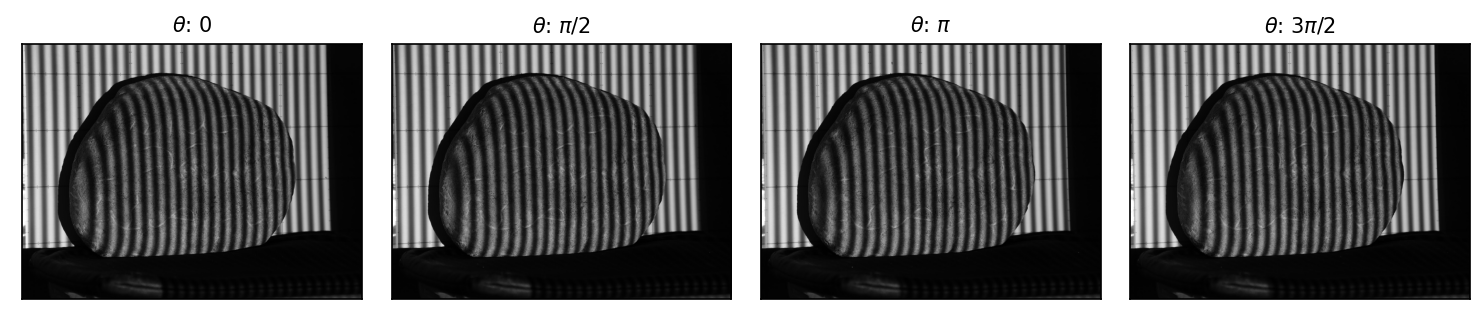

In [4]:
plt.figure(figsize= [10,4], dpi = 150)

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(F[i], 'gray')
    plt.title("$\\theta$: " + str(Theta[i]), fontsize = 10)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Perspective transformation

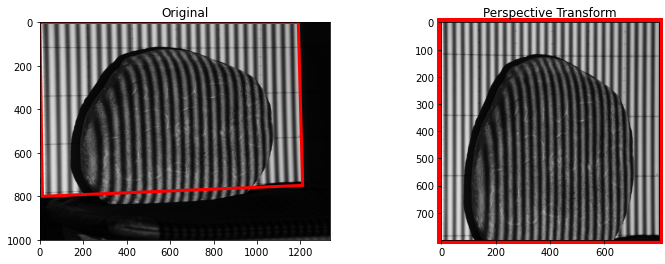

In [5]:

dim = 800

IMG = F[0]
pts1 = np.float32([[0,0],[1190,0],[12,800],[1210,750]])
pts2 = np.float32([[0,0],[800,0],[0,800],[800,800]])
M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(IMG,M,(800,800))

fig,ax = plt.subplots(1,2, figsize = [12,4])
ax[0].set_title("Original")
ax[0].imshow(IMG, 'gray')

polygon1 = Polygon([(0,0), (1190,0),(1210,750), (12,800)], fill = False, ec = 'r', lw = 3)
ax[0].add_patch(polygon1)

# plt.subplot(122)
ax[1].set_title("Perspective Transform")
ax[1].imshow(dst, 'gray')
ax[1].patch.set_edgecolor('r')  
ax[1].patch.set_linewidth('8')  
# plt.show()

## Object

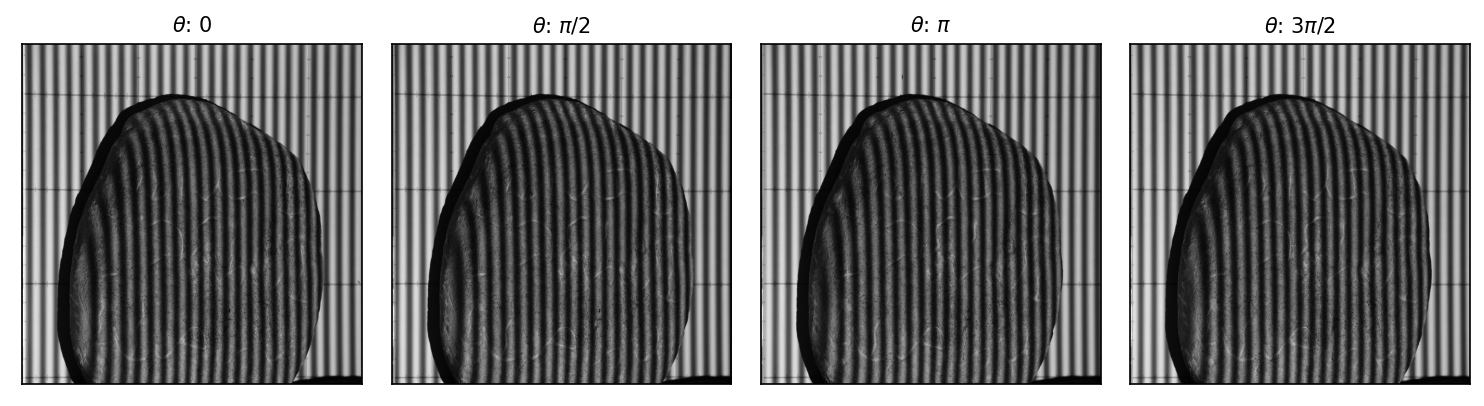

In [6]:
%matplotlib inline 

Object = []
plt.figure(figsize=(10,4), dpi = 150)

for i in range(4):
    pts1 = np.float32([[0,0],[1190,0],[12,800],[1210,750]])
    pts2 = np.float32([[0,0],[800,0],[0,800],[800,800]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    IMG = cv2.warpPerspective(F[i],M,(800,800))
    Object.append(IMG)
    
    plt.subplot(1,4,i+1)
    plt.imshow(IMG, 'gray')
    plt.title("$\\theta$: " + str(Theta[i]), fontsize = 10)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Flat Reference

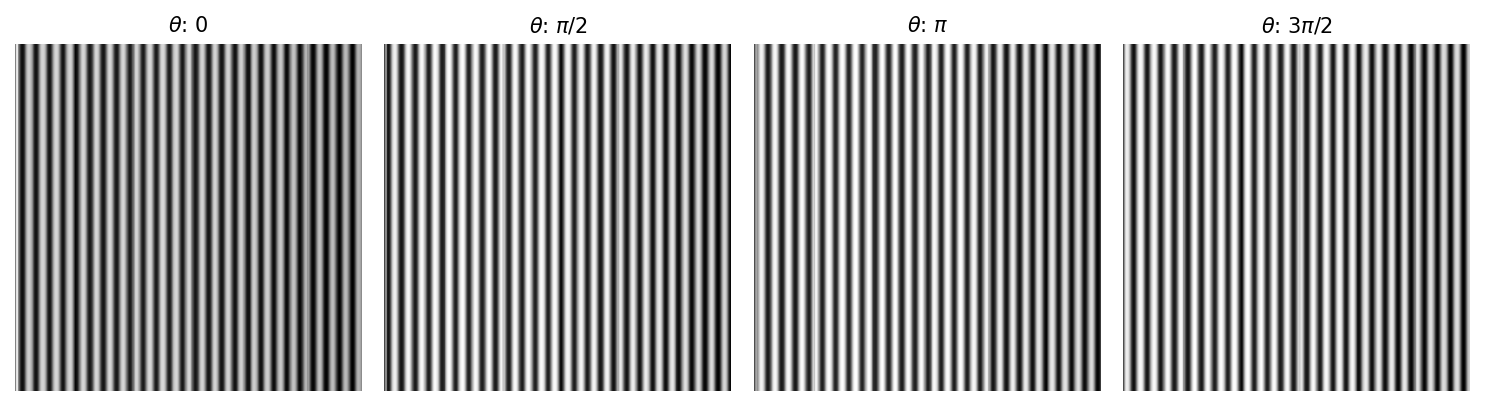

In [7]:
Flat = []
plt.figure(figsize=(10,4), dpi = 150)

for i in range(4):
    flat = np.zeros(shape=(800,800))
    flat[:,:] = Object[i][:100,:].mean(axis=0)
    Flat.append(flat)
    plt.subplot(1,4,i+1)
    plt.imshow(flat, 'gray')
    plt.axis("off")
    plt.title("$\\theta$: " + str(Theta[i]), fontsize = 10)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Intensity Profile

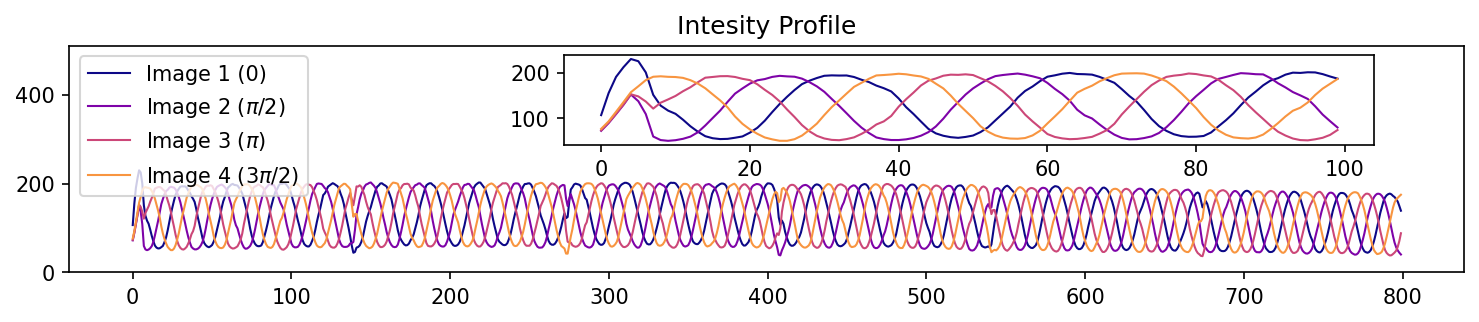

In [13]:
fig = plt.figure(figsize=(12,2), dpi = 150)
plt.title("Intesity Profile")
for i in range(4):
    plt.plot(Flat[i][0,:], color = plt.cm.plasma(i/4), lw = 1,
             label = "Image " + str(i+1) + " (" +  str(Theta[i]) + ")")

plt.ylim(0,510)
plt.legend(loc = 2)



left, bottom, width, height = [0.4, 0.55, 0.45, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])
for i in range(4):
    ax2.plot(Flat[i][0,0:100], color = plt.cm.plasma(i/4), lw = 1,
             label = "Image " + str(i+1) + " (" +  str(Theta[i]) + ")")


# 3D Visualization `function()`

In [62]:
def Profile_3D(reconstructed, XX, YY):
    %matplotlib notebook
    X,Y = np.meshgrid(range(XX), range(YY))

    fig = plt.figure(figsize = [5,4], dpi = 150)
    plt.rcParams.update({'font.size': 5})
    ax = fig.add_subplot(111, projection='3d')

    p = ax.plot_surface(-X, Y, reconstructed, cmap = 'plasma', rstride=1, cstride=1)
    ax.view_init(elev = 25,azim=30)
    plt.colorbar(p, shrink = 0.5)
    plt.show()
    plt.tight_layout()

# Phase Shift Profilometry

### `01: Cropping of ROI (Region of Interest)`
### `02: Subtracting like terms`
### `03: Subtracting like terms`
### `04: Solving for the Phase`
### `05: Phase unwrapping`
### `06: Recovery`
### `07: 2D Fourier Filtering`


In [100]:
def PhaseShiftProfilometry(FFT, thck, dist):

    '01: Cropping of ROI (Region of Interest)'
    
    xy = cv2.selectROI(Object[0])

    FLAT_m = []
    OBJ1_m = []

    for i in range(4):
        obj_crop = Object[i][int(xy[1]):int(xy[1]+xy[3]), int(xy[0]):int(xy[0]+xy[2])]
        OBJ1_m.append(obj_crop)

        flat_crop = Flat[i][int(xy[1]):int(xy[1]+xy[3]), int(xy[0]):int(xy[0]+xy[2])]
        FLAT_m.append(flat_crop)
        
    %matplotlib inline        
    fig,ax = plt.subplots(2,1, figsize = [5,8])
    ax[0].set_title("Original")
    ax[0].imshow(Object[0], 'gray')
    rect = Rectangle((xy[0],xy[1]), xy[2],xy[3], linewidth=2,edgecolor='r',facecolor='none')
    ax[0].add_patch(rect)
    ax[0].annotate("ROI", (xy[0]+xy[2]/5, xy[1]+xy[3]/2), color = 'r', fontsize = 15)
    
    ax[1].set_title("Region of Interest")
    ax[1].imshow(Object[0][int(xy[1]):int(xy[1]+xy[3]), int(xy[0]):int(xy[0]+xy[2])], cmap = 'gray')
    ax[1].patch.set_edgecolor('r')  
    ax[1].patch.set_linewidth('8')  
    plt.tight_layout()
    plt.show()
        
    '02: Subtracting like terms'

    I_flat = [np.mean(FLAT_m[0]) + FLAT_m[0]*np.cos(theta[0]), 
              np.mean(FLAT_m[1]) - FLAT_m[1]*np.sin(theta[1]), 
              np.mean(FLAT_m[2]) - FLAT_m[2]*np.cos(theta[2]),
              np.mean(FLAT_m[3]) + FLAT_m[3]*np.sin(theta[3])]
    I_obj =  [np.mean(OBJ1_m[0]) + OBJ1_m[0]*np.cos(theta[0]),
              np.mean(OBJ1_m[1]) - OBJ1_m[1]*np.sin(theta[1]), 
              np.mean(OBJ1_m[2]) - OBJ1_m[2]*np.cos(theta[2]),
              np.mean(OBJ1_m[3]) + OBJ1_m[3]*np.sin(theta[3])]

    '03: Subtracting like terms'
    '04: Solving for the Phase'

    phase_f = np.arctan2((I_flat[3]-I_flat[1]),(I_flat[0]-I_flat[2])).astype(float)
    phase_o = np.arctan2((I_obj[3]-I_obj[1]),(I_obj[0]-I_obj[2])).astype(float)

    %matplotlib inline
    plt.rcParams.update({'font.size': 6, 'axes.titlesize': 10})
    
    plt.figure(figsize = [10,3], dpi = 150)

    plt.subplot(131)
    plt.title("Region of Interest")
    plt.imshow(Object[0][int(xy[1]):int(xy[1]+xy[3]), int(xy[0]):int(xy[0]+xy[2])], cmap = 'gray')

    plt.subplot(132)
    plt.title("Phase: Flat Reference")
    plt.imshow(phase_f, cmap = 'gray')
    # plt.colorbar()
    plt.subplot(133)
    plt.title("Phase: Object")
    plt.imshow(phase_o, cmap = 'gray')
    # plt.colorbar()
    plt.show()
    
    
    '05: Phase unwrapping'

    unwrapped_flat = np.unwrap(phase_f,discont=1.5*np.pi, axis=-1)
    unwrapped_obj1 = np.unwrap(phase_o,discont=1.5*np.pi, axis=-1)

    '06: Recovery'
    
    rec = -(unwrapped_flat-unwrapped_obj1)

    %matplotlib inline
    plt.rcParams.update({'font.size': 6, 'axes.titlesize': 10})

    plt.figure(figsize = [10,3], dpi = 150)

    plt.subplot(131)
    plt.title("Unwrapped: Flat Reference")
    plt.imshow(unwrapped_flat, cmap = 'gray')
    # plt.colorbar()
    plt.subplot(132)
    plt.title("Unwrapped: Object")
    plt.imshow(unwrapped_obj1, cmap = 'gray')
    # plt.colorbar()

    plt.subplot(133)
    plt.title("Reconstructed")
    plt.imshow(rec, cmap = 'gray')
    # plt.colorbar()
    plt.show()

    
    '07: 2D Fourier Filtering'
    
    if FFT == True:
        
        plt.figure(figsize = [10,3], dpi = 150)
        plt.rcParams.update({'font.size': 6, 'axes.titlesize': 10})

        rec_ft = fftshift(fft2(rec))
        plt.subplot(131)
        plt.title("Fourier Transform")
        plt.imshow(np.log(abs(rec_ft)), cmap='gray');


        rec_ft[:xy[3]//2-dist, xy[2]//2 - thck:xy[2]//2 +thck] = i
        rec_ft[-xy[3]//2 + dist:, xy[2]//2 - thck:xy[2]//2 +thck] = i
        rec_ft[xy[3]//2 - thck:xy[3]//2 +thck, :xy[2]//2-dist] = i
        rec_ft[xy[3]//2 - thck:xy[3]//2 +thck, -xy[2]//2 + dist:] = i

        plt.subplot(132)
        plt.title("Fourier Filtering")
        plt.imshow(np.log(abs(rec_ft)), cmap='gray')
        recovered = np.abs(ifft2(ifftshift(rec_ft)))
        plt.subplot(133)
        plt.title("Recovered")
        plt.imshow(recovered, cmap='gray')
        plt.show()
        
        Profile_3D(recovered, int(xy[2]), int(xy[3]))
        return recovered
    
    else:
        Profile_3D(rec, int(xy[2]), int(xy[3]))
        return rec
    

## ROI 1

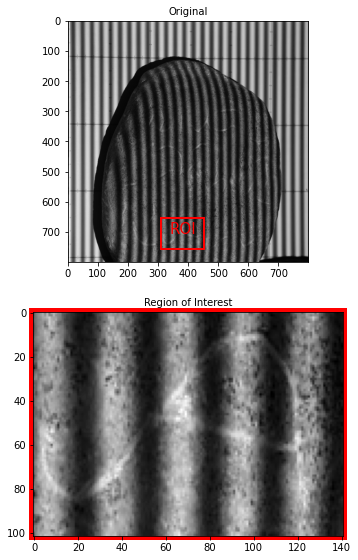

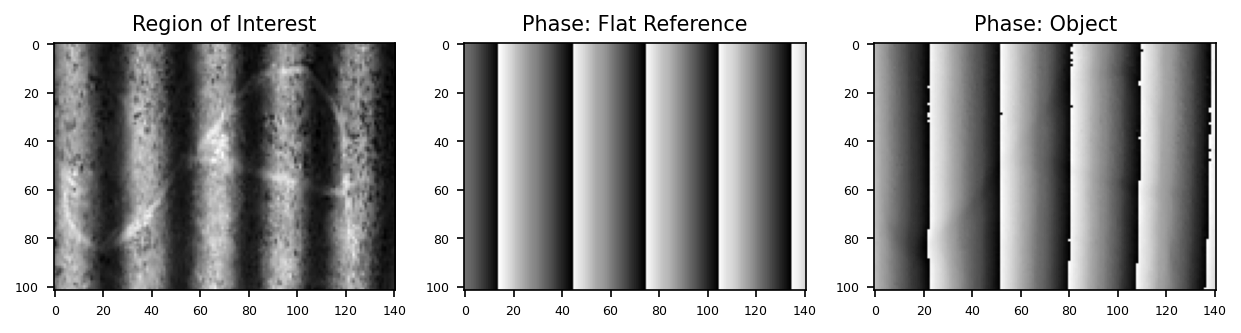

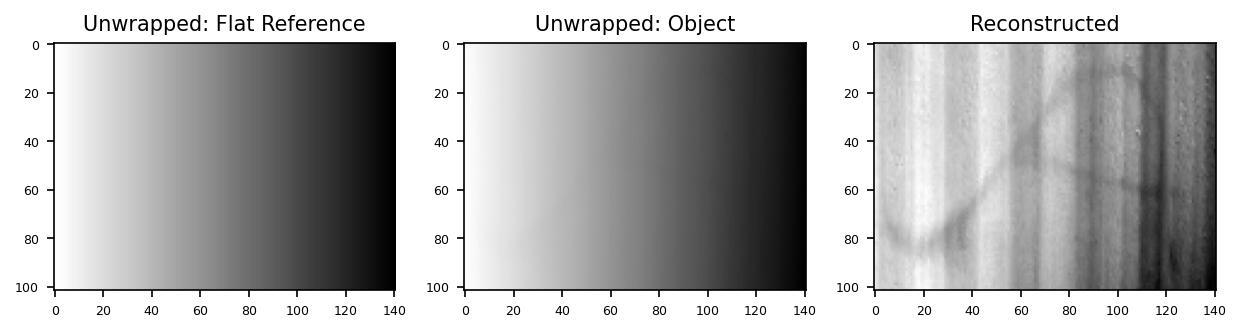

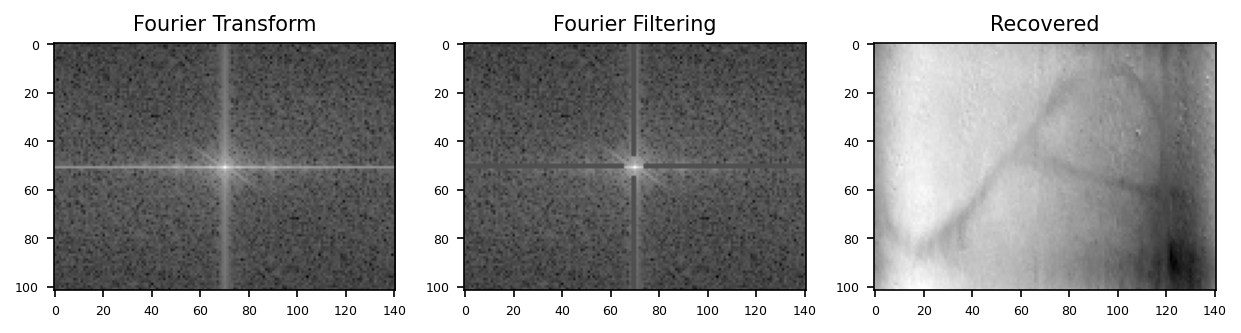

<IPython.core.display.Javascript object>


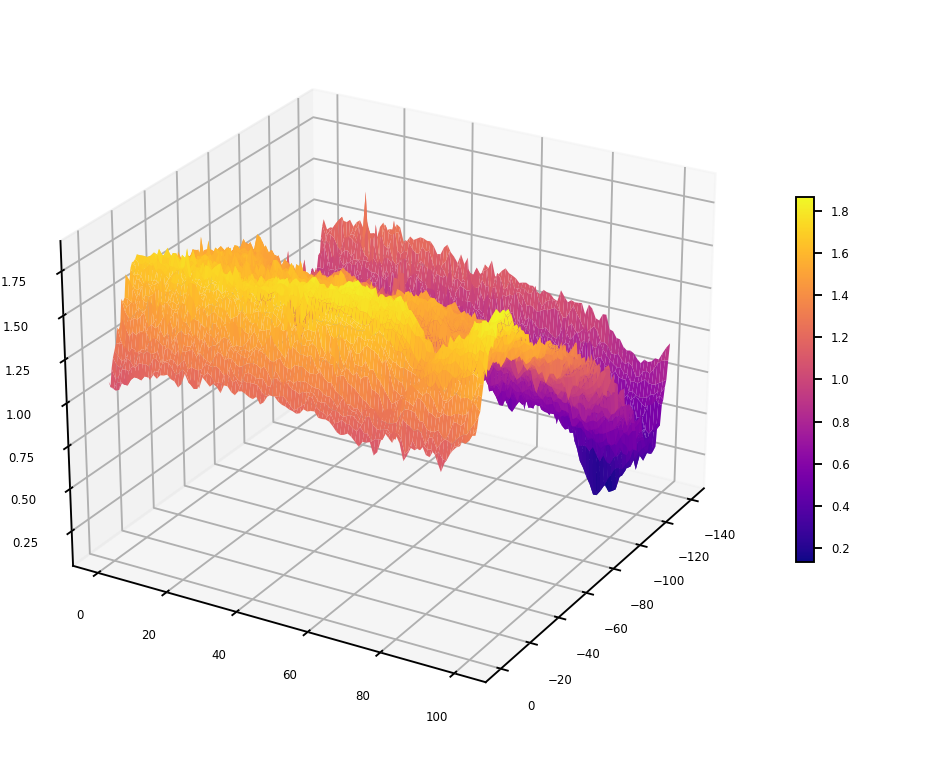

In [101]:
Profile1 = PhaseShiftProfilometry(FFT = True, thck = 1, dist = 4)

## ROI 2

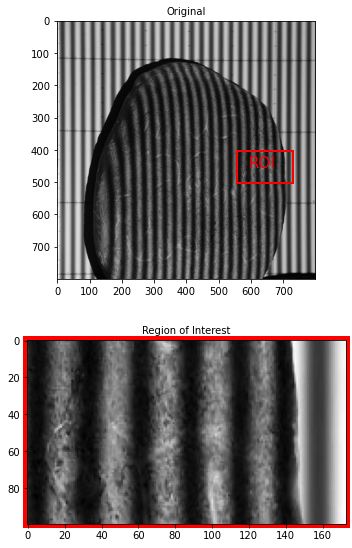

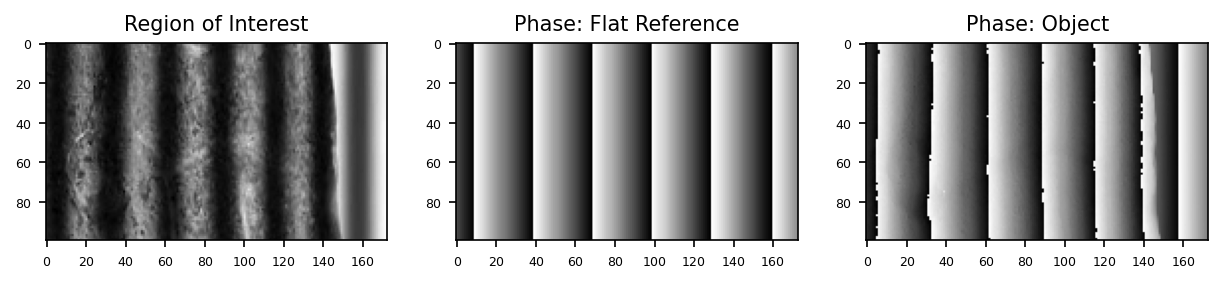

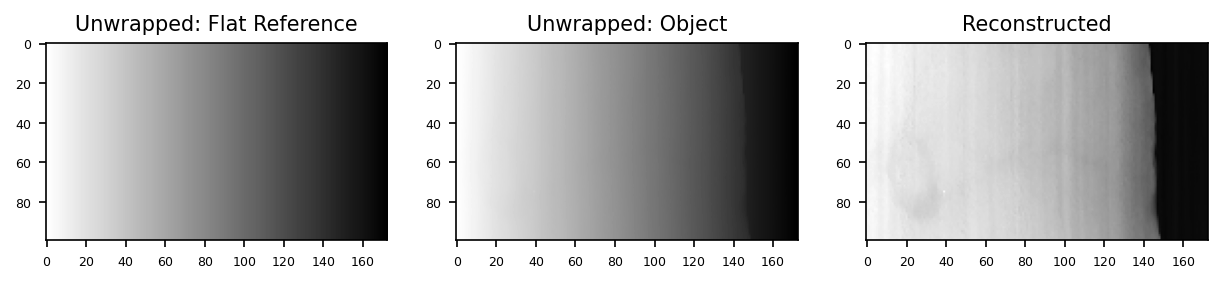

<IPython.core.display.Javascript object>


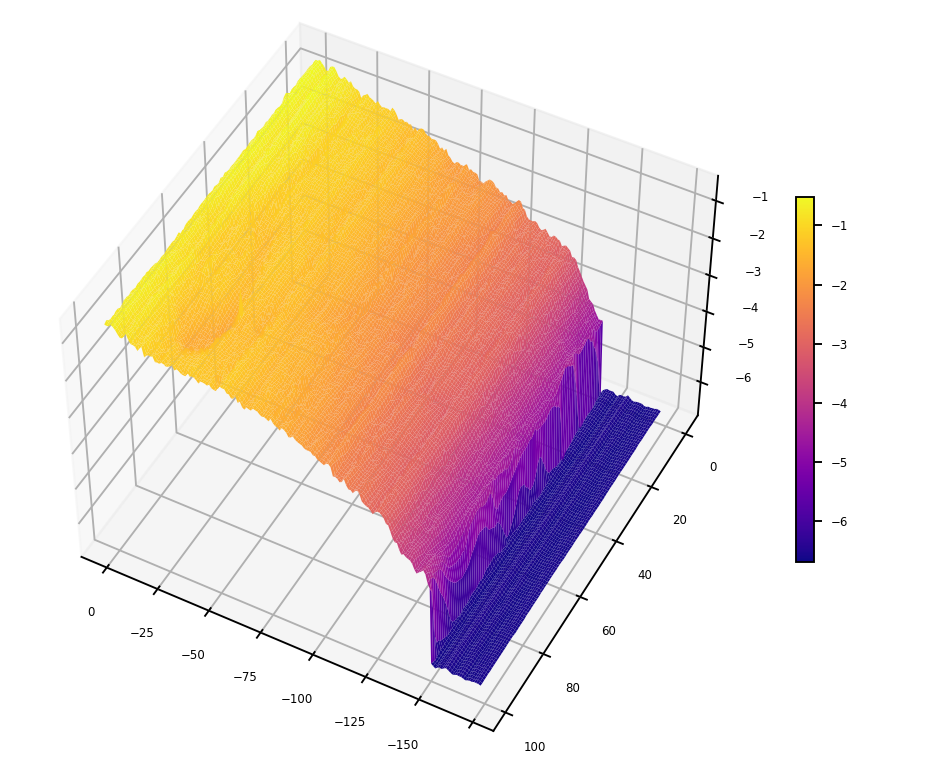

In [102]:
Profile2 = PhaseShiftProfilometry(FFT = False, thck = 1, dist = 3)

## ROI 3

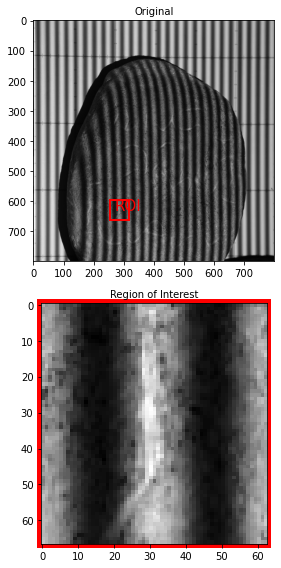

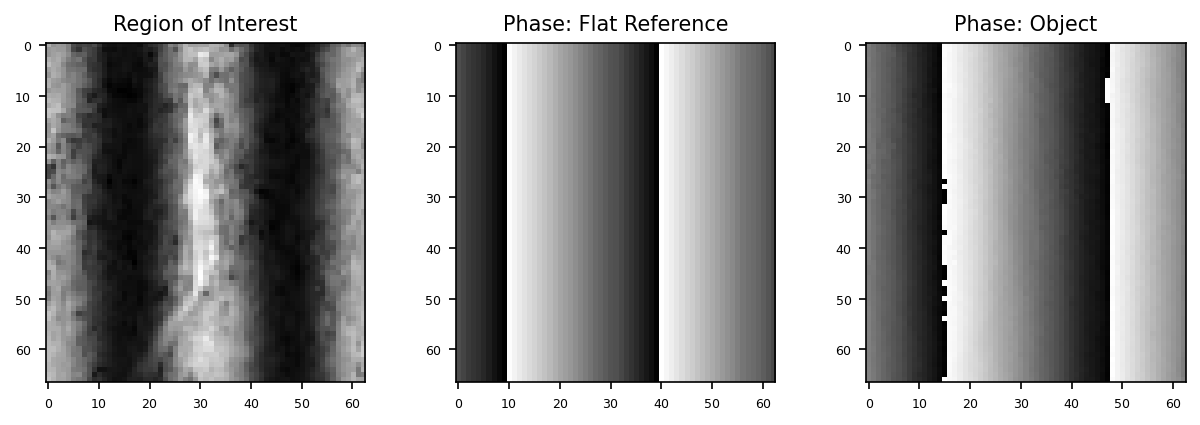

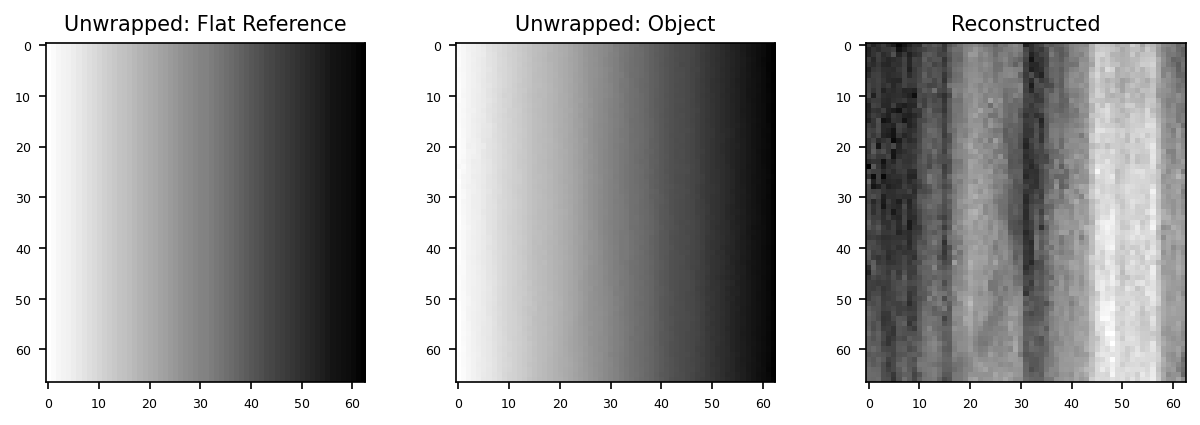

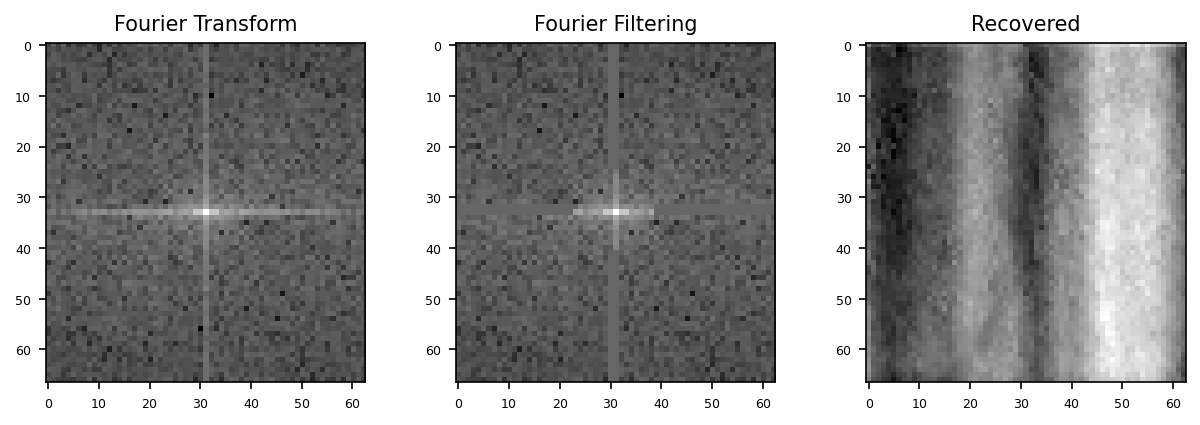

<IPython.core.display.Javascript object>


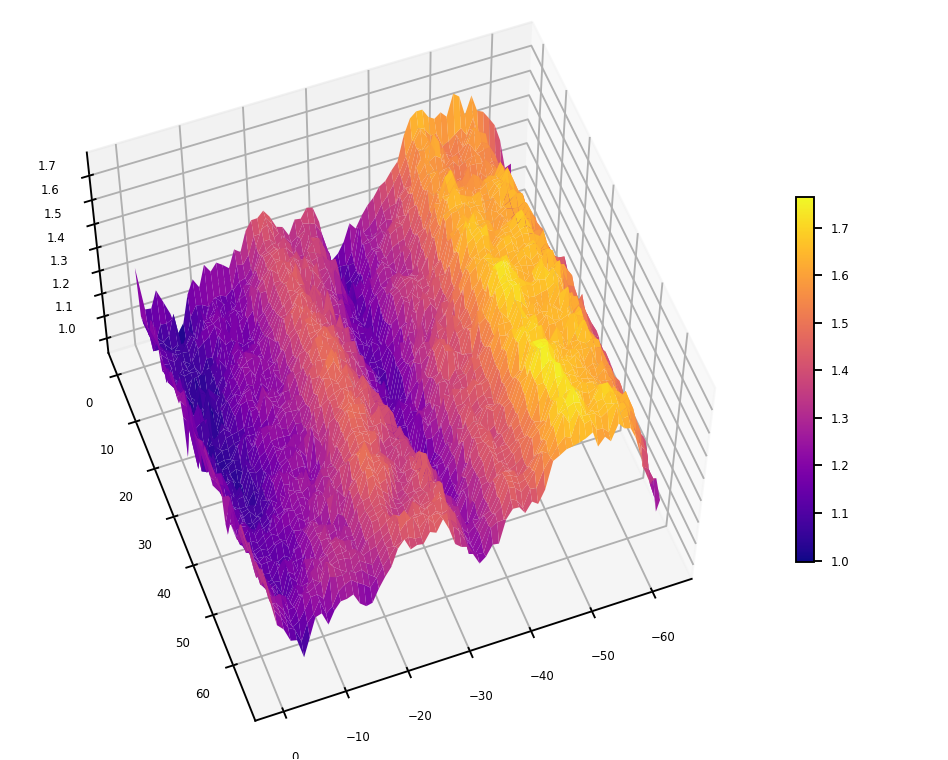

In [107]:
Profile3 = PhaseShiftProfilometry(FFT = True, thck = 1, dist = 8)

## ROI 4

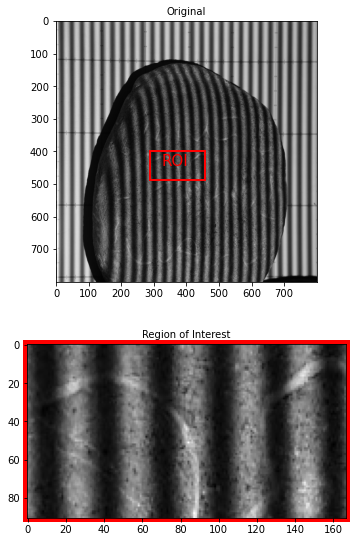

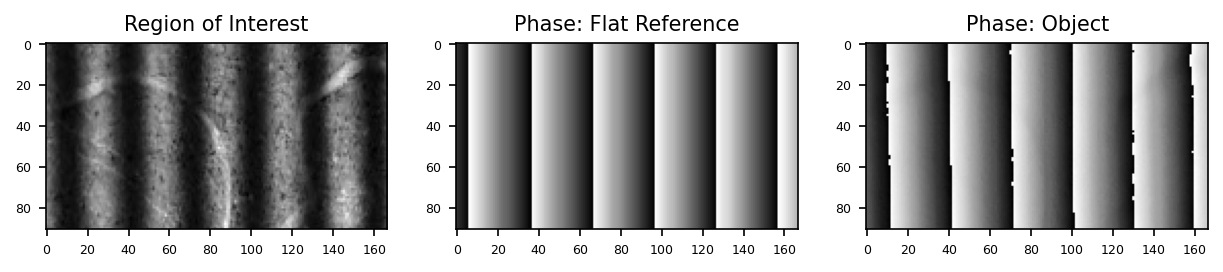

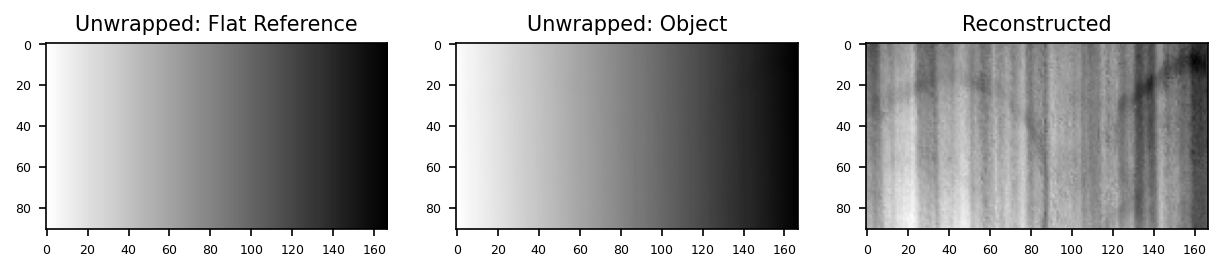

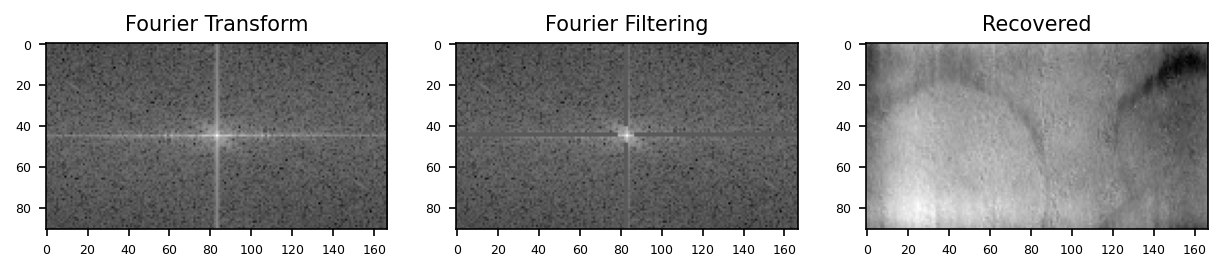

<IPython.core.display.Javascript object>


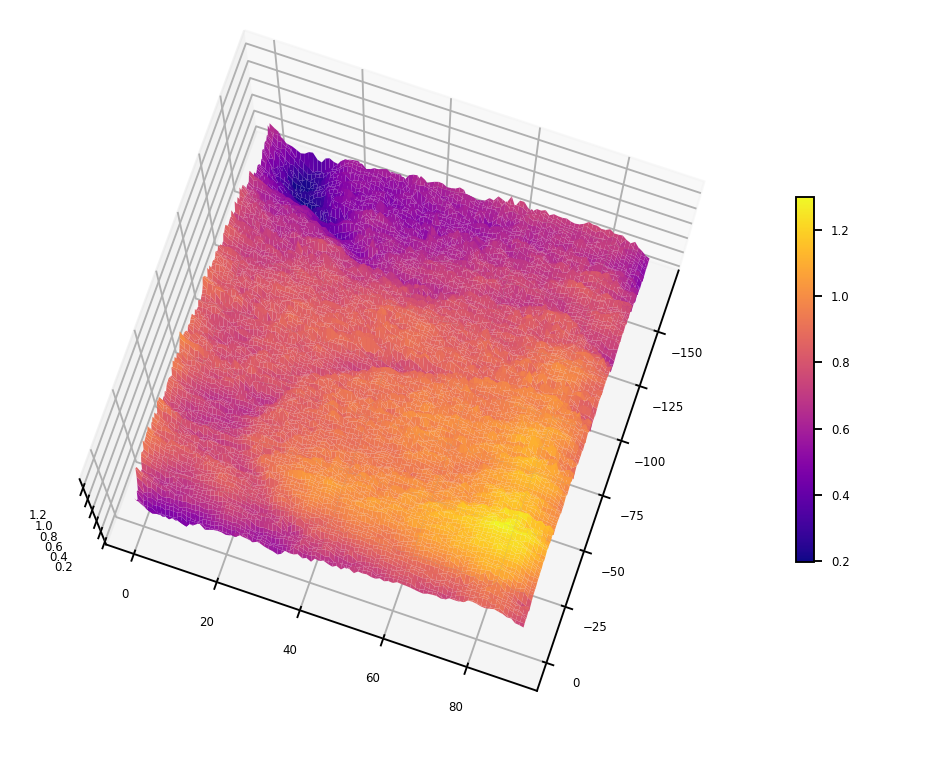

In [114]:
Profile4 = PhaseShiftProfilometry(FFT = True, thck = 1, dist = 4)

## ROI 5

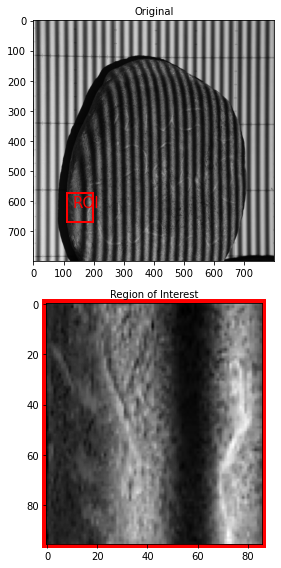

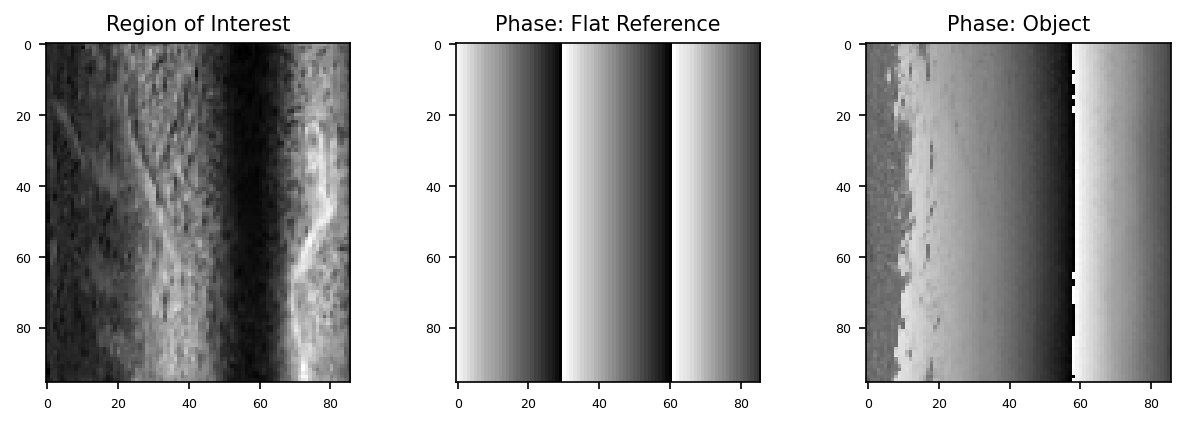

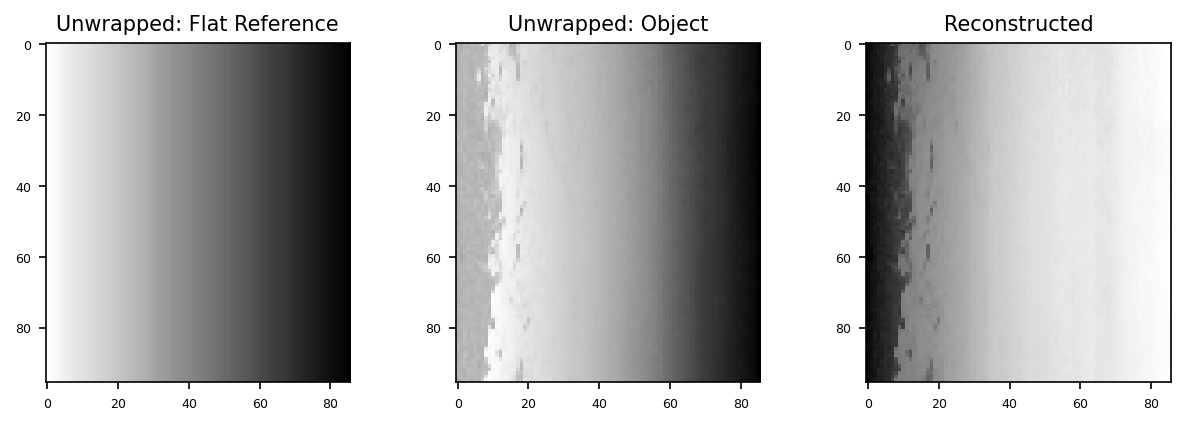

<IPython.core.display.Javascript object>


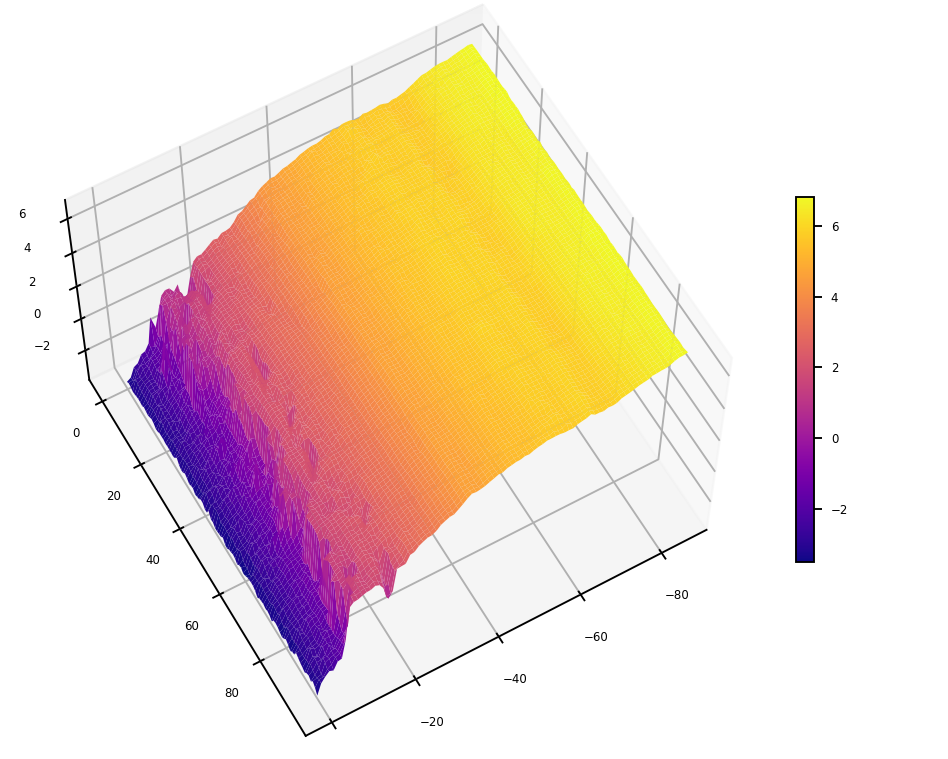

In [123]:
Profile5 = PhaseShiftProfilometry(FFT = False, thck = 1, dist = 3)

# ROI 6

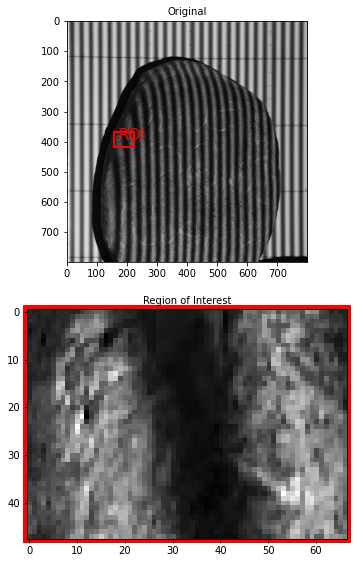

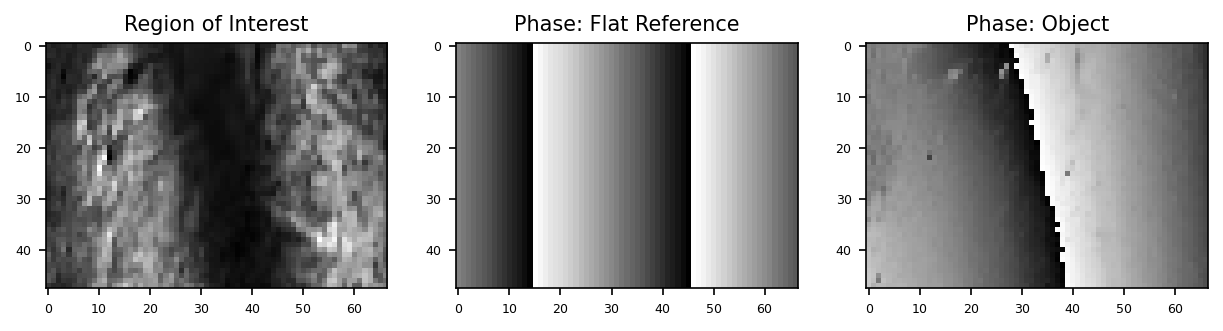

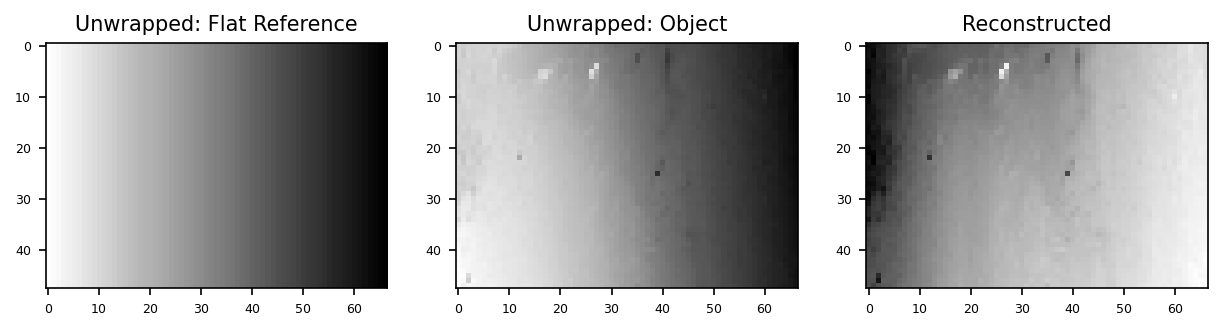

<IPython.core.display.Javascript object>


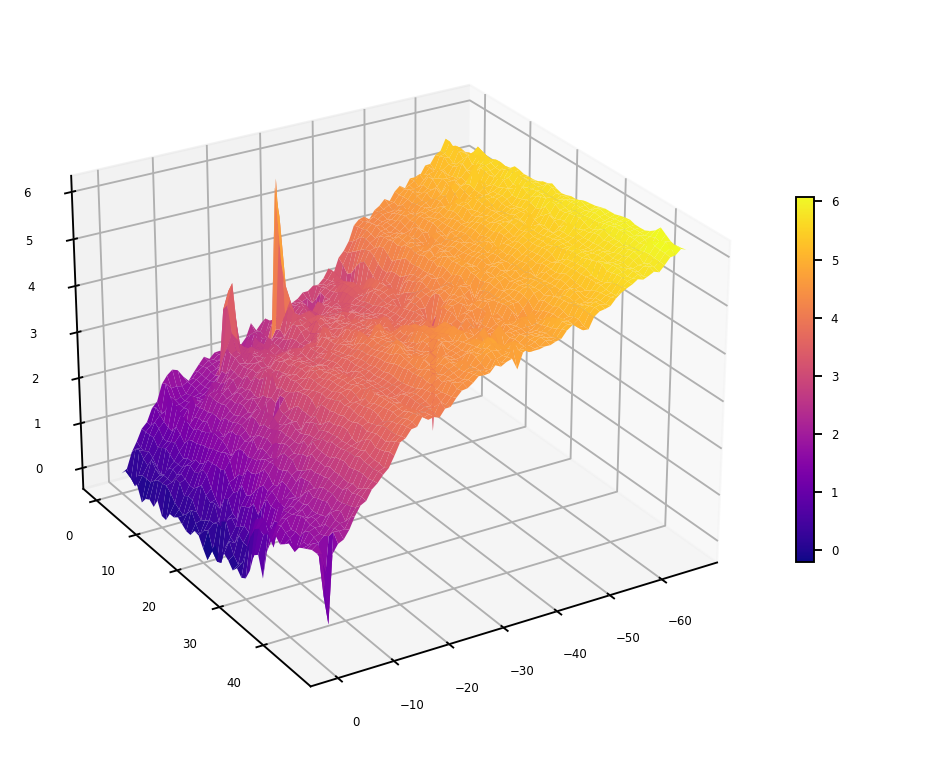

In [136]:
Profile6 = PhaseShiftProfilometry(FFT = False, thck = 1, dist = 8)

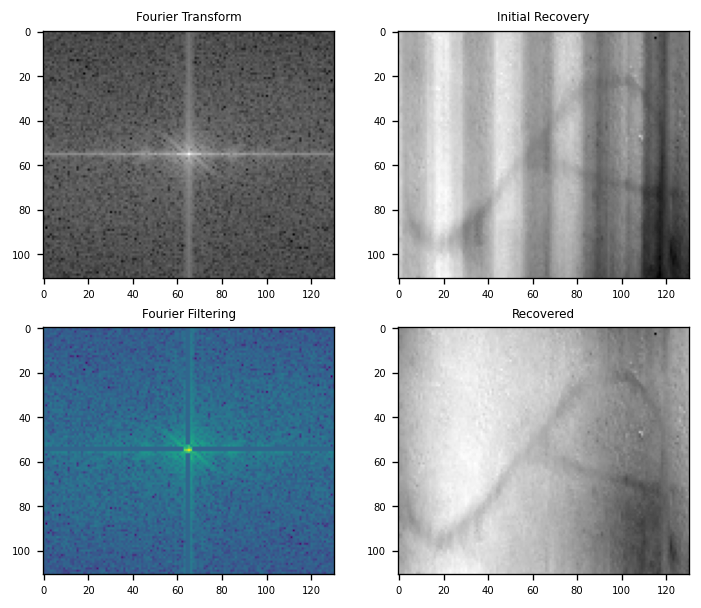

In [276]:
%matplotlib inline
plt.rcParams.update({'font.size': 6})

plt.figure(figsize = [7,6], dpi = 120)

rec_ft = fftshift(fft2(rec))
plt.subplot(221)
plt.title("Fourier Transform")
plt.imshow(np.log(abs(rec_ft)), cmap='gray');
plt.subplot(222)
plt.title("Initial Recovery")
plt.imshow(rec, cmap='gray');

thck = 1
dist = 2


rec_ft[:xy[3]//2-dist, xy[2]//2 - thck:xy[2]//2 +thck] = i
rec_ft[-xy[3]//2 + dist:, xy[2]//2 - thck:xy[2]//2 +thck] = i
rec_ft[xy[3]//2 - thck:xy[3]//2 +thck, :xy[2]//2-dist] = i
rec_ft[xy[3]//2 - thck:xy[3]//2 +thck, -xy[2]//2 + dist:] = i

plt.subplot(223)
plt.title("Fourier Filtering")
plt.imshow(np.log(abs(rec_ft)))
recovered = abs(ifft2(rec_ft))
plt.subplot(224)
plt.title("Recovered")
plt.imshow(recovered, cmap='gray');

<IPython.core.display.Javascript object>


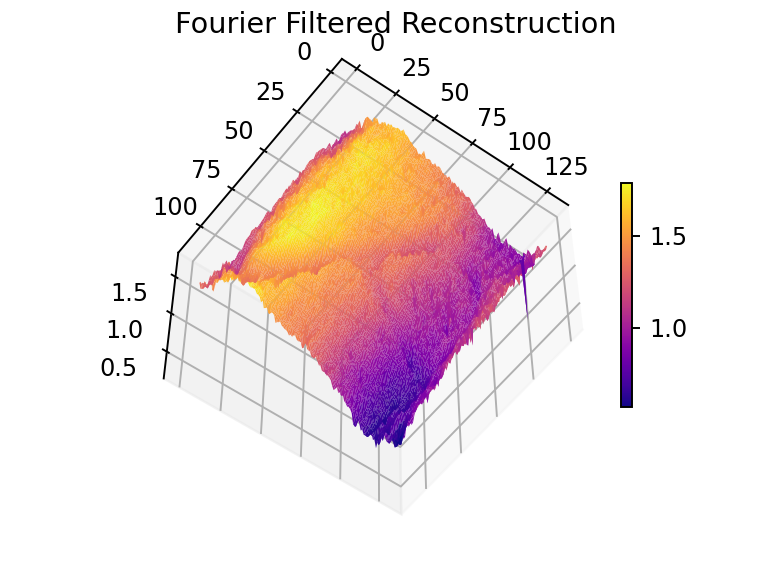

In [272]:
%matplotlib notebook

X,Y = np.meshgrid(range(int(xy[2])), range(int(xy[3])))

fig = plt.figure(figsize = [4,3], dpi = 150)
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("Fourier Filtered Reconstruction")

p = ax.plot_surface(X, Y, recovered, cmap = 'plasma', rstride=1, cstride=1)
ax.view_init(elev = 25,azim=30)
plt.colorbar(p, shrink = 0.5)

In [106]:
xy = cv2.selectROI(Object[0])
# roi = macbeth_[int(xy[1]):int(r_coords[1]+r_coords[3]),
#              int(r_coords[0]):int(r_coords[0]+r_coords[2])]

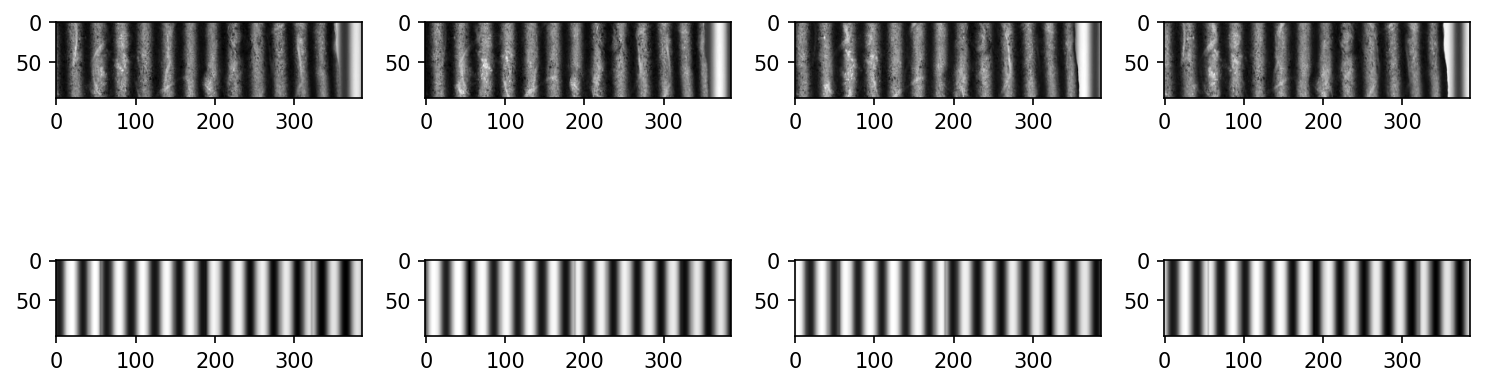

In [138]:
%matplotlib inline 

xy = cv2.selectROI(Object[0])

plt.figure(figsize=(10,4), dpi = 150)
FLAT_m = []
OBJ1_m = []

for i in range(4):
    plt.subplot(2,4,i+1)
    obj_crop = Object[i][int(xy[1]):int(xy[1]+xy[3]), int(xy[0]):int(xy[0]+xy[2])]
    plt.imshow(obj_crop, 'gray')
#     plt.colorbar()
    OBJ1_m.append(obj_crop)
#     plt.axis("off")
    
    plt.subplot(2,4,i+5)
    flat_crop = Flat[i][int(xy[1]):int(xy[1]+xy[3]), int(xy[0]):int(xy[0]+xy[2])]
    plt.imshow(flat_crop, 'gray')
#     plt.colorbar()
    FLAT_m.append(flat_crop)

#     plt.axis("off")
    
plt.tight_layout()

In [139]:
N = 1
for i in range(N):
    I1 = np.mean(FLAT_m[0]) + FLAT_m[0]*np.cos(theta[0])
    I2 = np.mean(FLAT_m[1]) - FLAT_m[1]*np.sin(theta[1])
    I3 = np.mean(FLAT_m[2]) - FLAT_m[2]*np.cos(theta[2])
    I4 = np.mean(FLAT_m[3]) + FLAT_m[3]*np.sin(theta[3])

    FLAT_m = [I1,I2,I3,I4]
    
for i in range(N):
    I1 = np.mean(OBJ1_m[0]) + OBJ1_m[0]*np.cos(theta[0])
    I2 = np.mean(OBJ1_m[1]) - OBJ1_m[1]*np.sin(theta[1])
    I3 = np.mean(OBJ1_m[2]) - OBJ1_m[2]*np.cos(theta[2])
    I4 = np.mean(OBJ1_m[3]) + OBJ1_m[3]*np.sin(theta[3])

    OBJ1_m = [I1,I2,I3,I4]

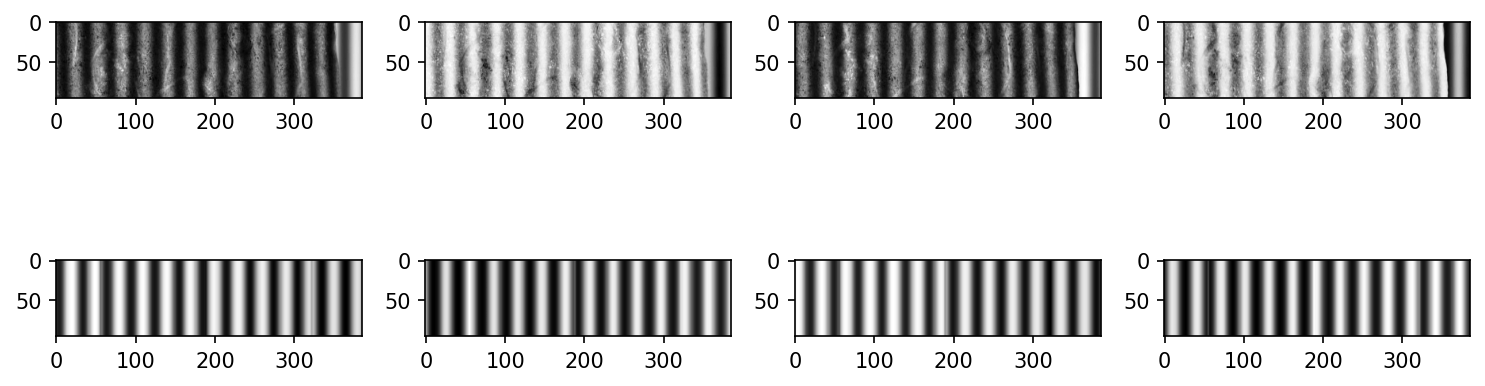

In [140]:
plt.figure(figsize=(10,4), dpi = 150)

for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(OBJ1_m[i], 'gray')
#     plt.colorbar()
#     plt.axis("off")
    
    plt.subplot(2,4,i+5)
    plt.imshow(FLAT_m[i], 'gray')
#     plt.colorbar()

#     plt.axis("off")
    
plt.tight_layout()

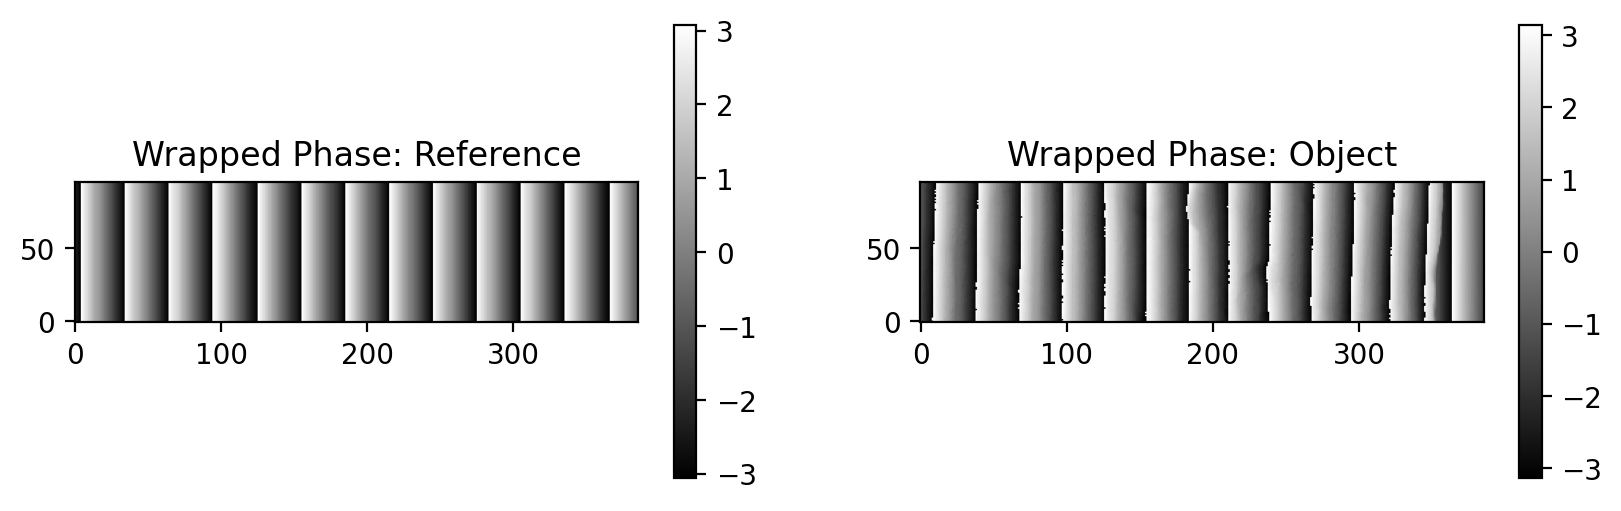

In [141]:
plt.figure(figsize = [10,3], dpi = 200)

phase_f = np.arctan2((FLAT_m[3]-FLAT_m[1]),(FLAT_m[0]-FLAT_m[2])).astype(float)
phase_o = np.arctan2((OBJ1_m[3]-OBJ1_m[1]),(OBJ1_m[0]-OBJ1_m[2])).astype(float)

plt.subplot(121)
plt.title("Wrapped Phase: Reference")
plt.imshow(phase_f, cmap = 'gray', origin = "lower")
plt.colorbar()
plt.subplot(122)
plt.title("Wrapped Phase: Object")
plt.imshow(phase_o, cmap = 'gray', origin = "lower")
plt.colorbar()
plt.show()

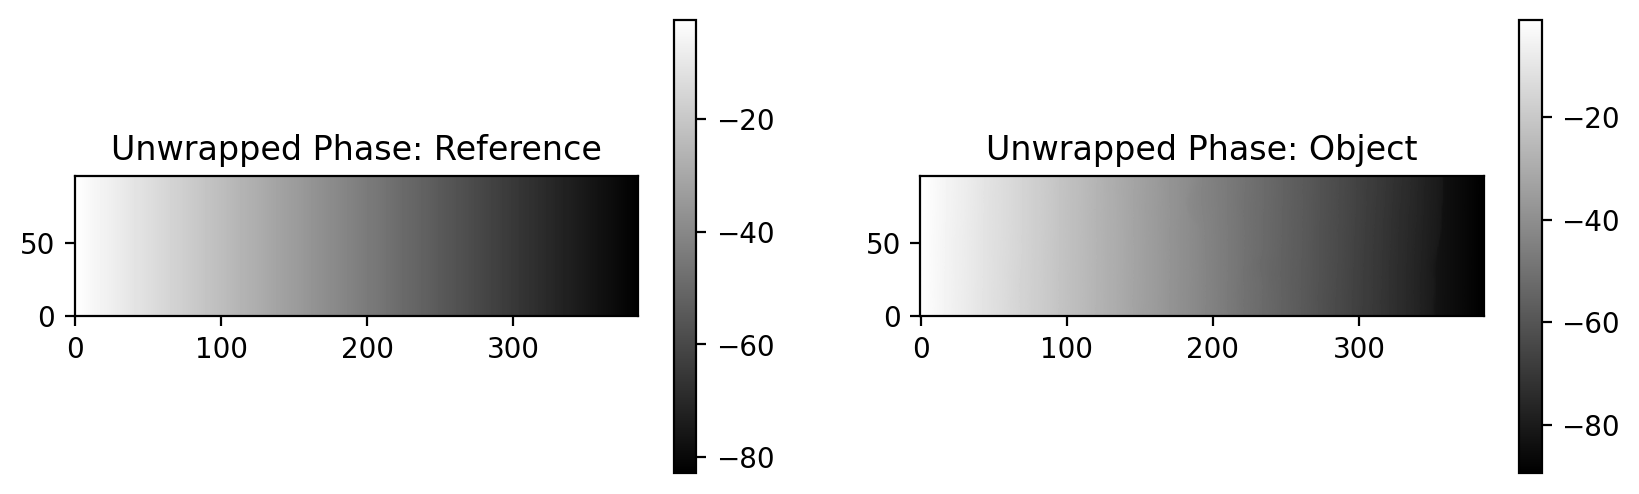

In [142]:
plt.figure(figsize = [10,3], dpi = 200)

unwrapped_flat = np.unwrap(phase_f,discont=1.5*np.pi, axis=-1)
unwrapped_obj1 = np.unwrap(phase_o,discont=1.5*np.pi, axis=-1)

plt.subplot(121)
plt.title("Unwrapped Phase: Reference")
plt.imshow(unwrapped_flat, cmap = 'gray', origin = "lower")
plt.colorbar()
plt.subplot(122)
plt.title("Unwrapped Phase: Object")
plt.imshow(unwrapped_obj1, cmap = 'gray', origin = "lower")
plt.colorbar()
plt.show()

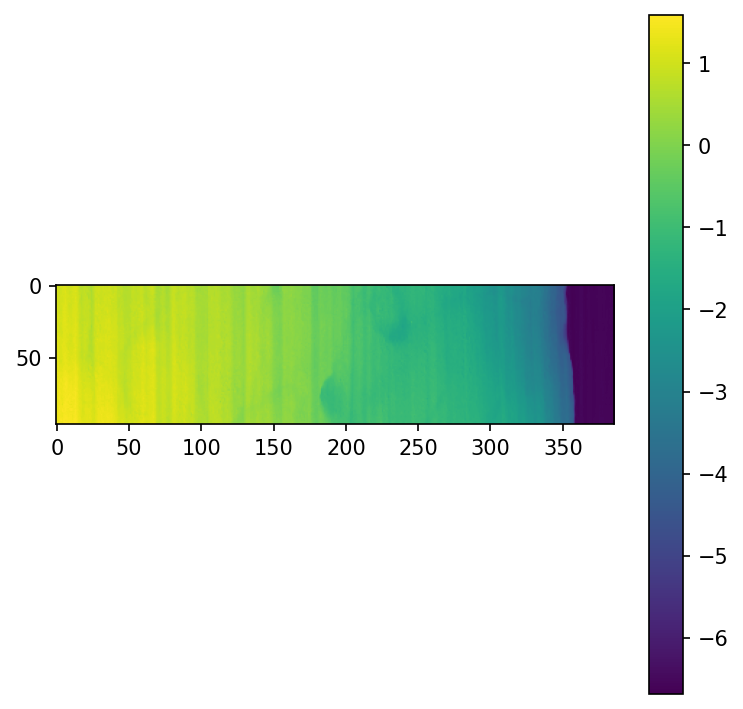

In [143]:
plt.figure(figsize = [6,6], dpi = 150)
rec = -(unwrapped_flat-unwrapped_obj1)
# rec[rec>1] = -10
plt.imshow(rec)
plt.colorbar()

<IPython.core.display.Javascript object>


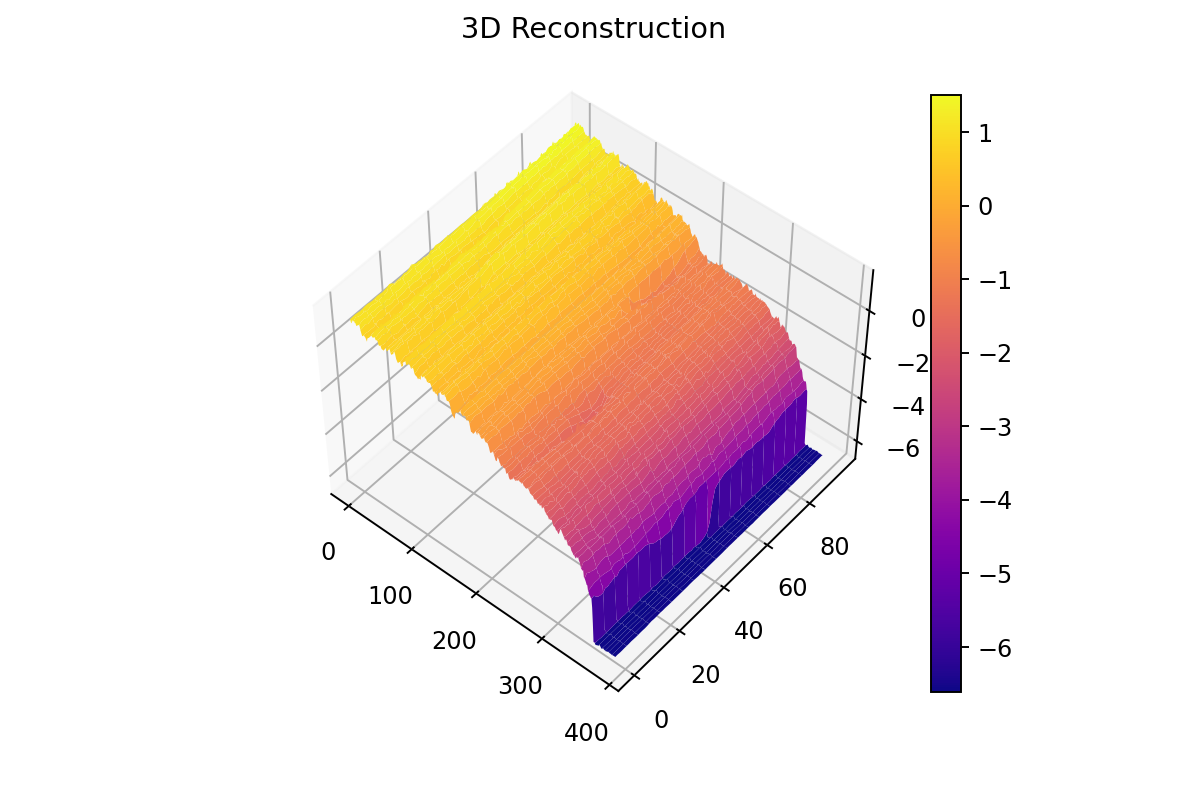

In [144]:
%matplotlib notebook

X,Y = np.meshgrid(range(int(xy[2])), range(int(xy[3])))

Z = rec

fig = plt.figure(figsize = [6,4], dpi = 150, facecolor = 'w')
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("3D Reconstruction")

# ax.set_zlim(0,15)
p = ax.plot_surface(X, Y, Z, cmap = 'plasma', rstride=5, cstride=5)
ax.view_init(elev = 25,azim=10)
plt.colorbar(p)


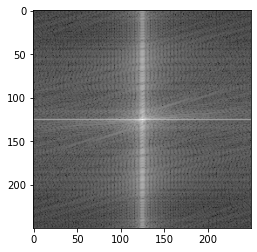

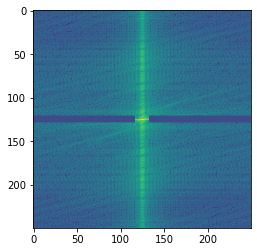

In [81]:
recovered = abs(np.fft.ifft2(rec_ft))

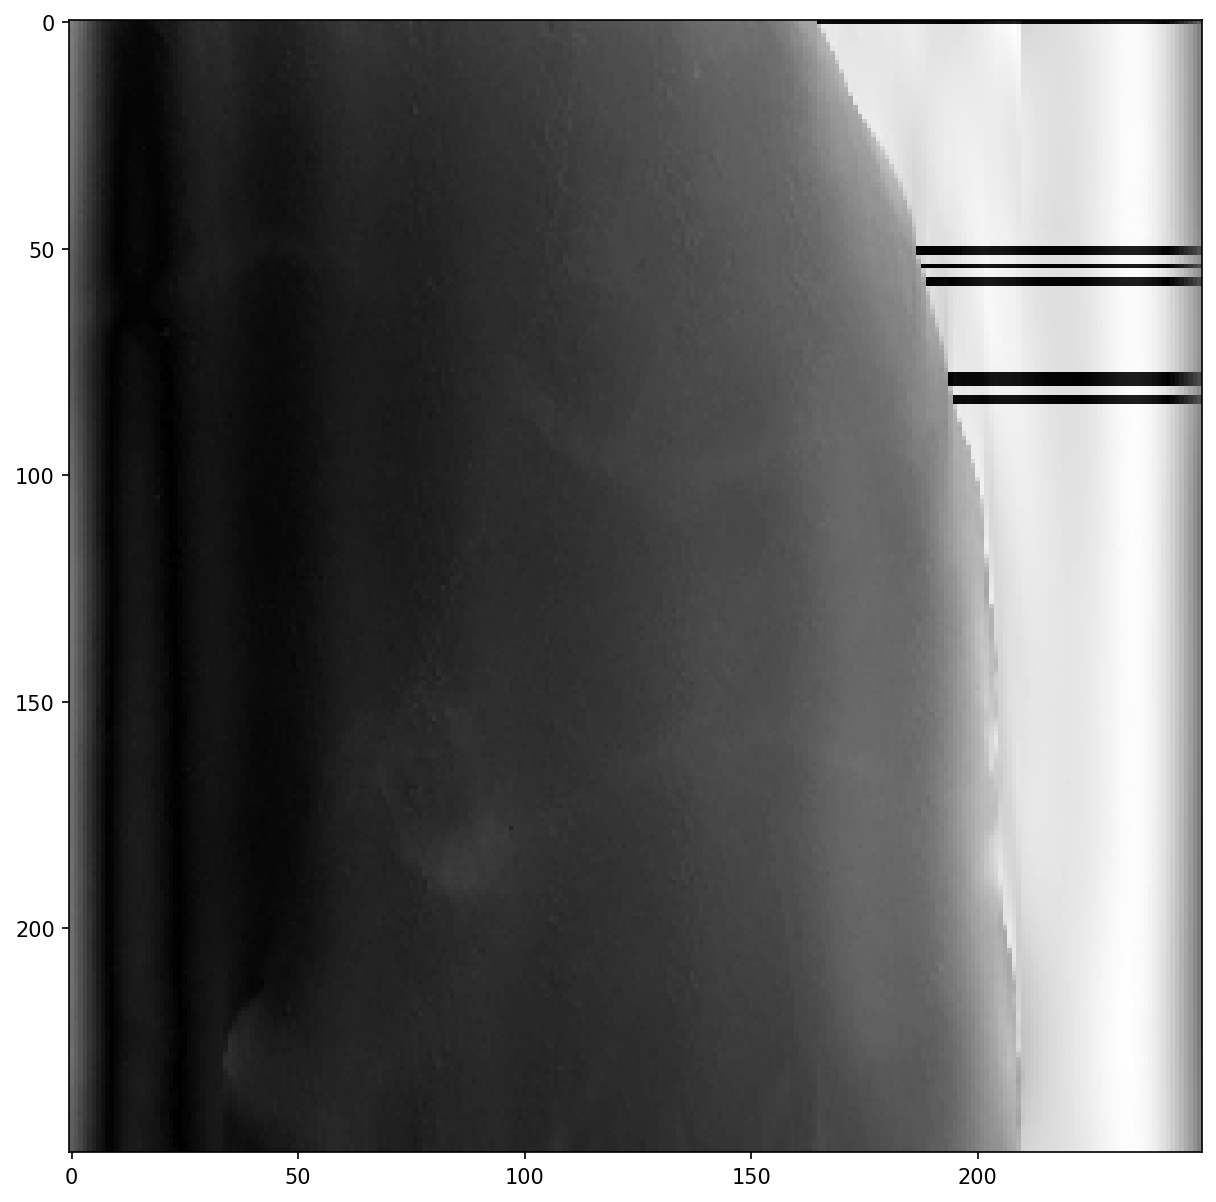

In [82]:
plt.figure(figsize = [10,10], dpi = 150)
plt.imshow(recovered, 'gray')

<IPython.core.display.Javascript object>


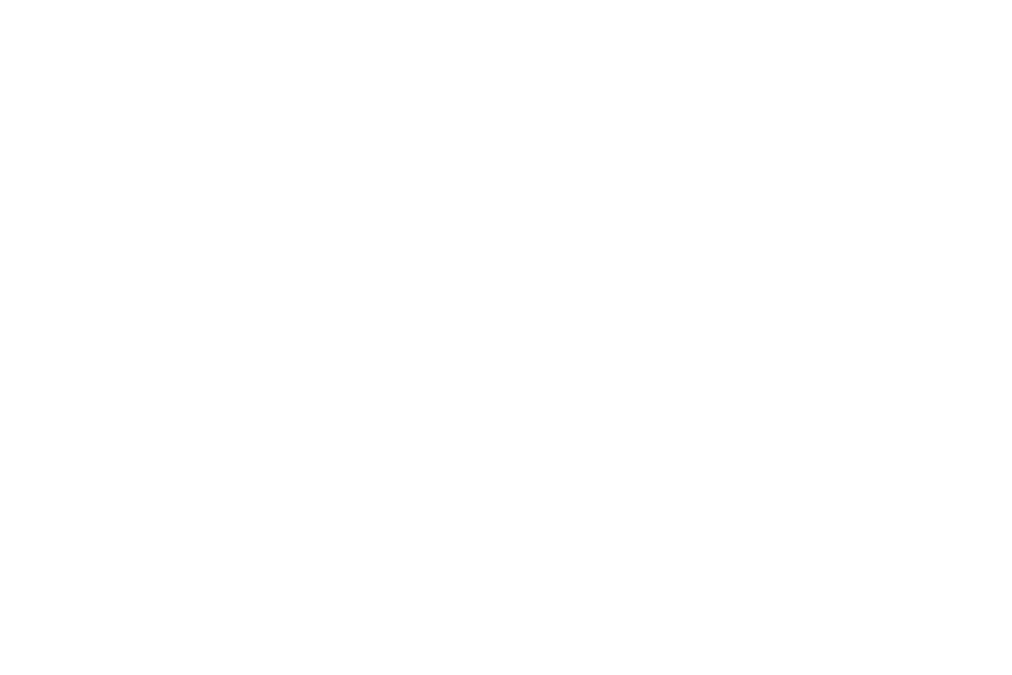

<IPython.core.display.Javascript object>


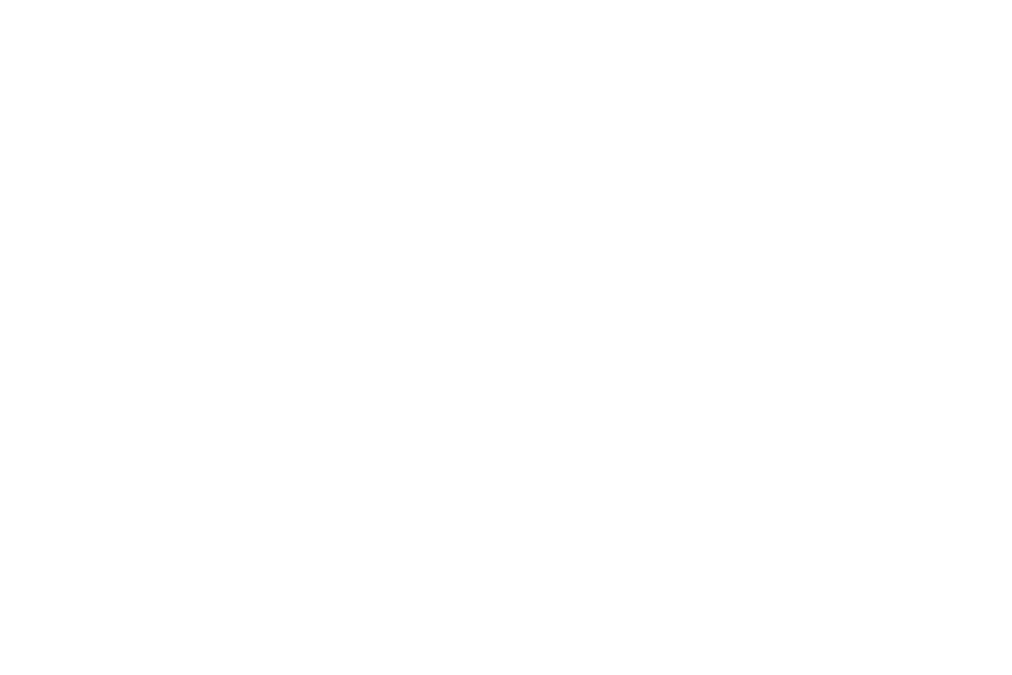

In [236]:
# %matplotlib notebook


X,Y = np.meshgrid(range(200), range(200))

Z = recovered

fig = plt.figure(figsize = [6,4], dpi = 150, facecolor = 'w')
plt.rcParams.update({'font.size': 10})
ax = fig.add_subplot(111, projection='3d')
plt.suptitle("3D Reconstruction")

# ax.set_zlim(0,15)
p = ax.plot_surface(X, Y, Z, cmap = 'plasma', rstride=5, cstride=5)
ax.view_init(elev = 25,azim=270)
plt.colorbar(p)

In [ ]:
# fig = plt.figure(figsize = [6,4], dpi = 150, facecolor = 'w')
# plt.rcParams.update({'font.size': 10})
# ax = fig.add_subplot(111, projection='3d')
# plt.suptitle("3D Reconstruction")

# ax.set_zlim(0,15)
# p = ax.plot_surface(X, Y, Z, cmap = 'jet', rstride=5, cstride=5)
# ax.view_init(elev = 55,azim=200)
# plt.colorbar(p)